# Expectation-Maximization: Practical session

## Imports

In [44]:
import numpy as np
from numpy import linalg
import librosa
import librosa.display
import os
import IPython.display as ipd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [ ]:
if not os.path.isdir('data'):
    !wget -O data.zip 'https://partage.imt.fr/index.php/s/nrNLrLSbDfNNrQQ/download'
    !mkdir data
    !unzip data.zip -d data
    !rm data.zip

--2023-02-08 09:48:52--  https://partage.imt.fr/index.php/s/nrNLrLSbDfNNrQQ/download
Resolving partage.imt.fr (partage.imt.fr)... 193.48.235.12
Connecting to partage.imt.fr (partage.imt.fr)|193.48.235.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘data.zip’

data.zip                [             <=>    ] 275.34M   754KB/s    in 6m 18s  

2023-02-08 09:55:10 (746 KB/s) - ‘data.zip’ saved [288711340]

Archive:  data.zip
   creating: data/MI205-TP3-Data/
 extracting: data/MI205-TP3-Data/accompaniment_no_drums.wav  
 extracting: data/MI205-TP3-Data/accompaniment.wav  
 extracting: data/MI205-TP3-Data/noise_easy.wav  
 extracting: data/MI205-TP3-Data/noise_hard.wav  
 extracting: data/MI205-TP3-Data/voice_only.wav  


## Data extraction

We use data from the MUSDB18 dataset.

In [45]:
sr = int(16e3) # Sample rate
data_path = os.path.join('data','MI205-TP3-Data') # Path of the data
# This might take some time, maybe save the npy compressed data directly
voice_only,_ = librosa.load(os.path.join(data_path,'voice_only.wav'),sr=sr)
accompaniment,_=librosa.load(os.path.join(data_path,'accompaniment_no_drums.wav'),sr=sr)

sample_begin=0
sample_end=min(20*sr,len(accompaniment))
voice_only=voice_only[sample_begin:sample_end]
accompaniment=accompaniment[sample_begin:sample_end]
mix=voice_only + accompaniment

In [46]:
print('mixture')
ipd.display(ipd.Audio(data=mix,rate=sr))
print('voice only')
ipd.display(ipd.Audio(data=voice_only,rate=sr))
print('accompaniment')
ipd.display(ipd.Audio(data=accompaniment,rate=sr))

Output hidden; open in https://colab.research.google.com to view.

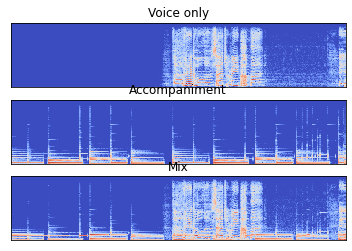

In [47]:
n_fft=2048
mix_stft = librosa.stft(mix, n_fft=n_fft)
voice_only_stft = librosa.stft(voice_only, n_fft=n_fft)
accompaniment_stft = librosa.stft(accompaniment, n_fft=n_fft)

fig, (ax1,ax2,ax3)=plt.subplots(3,1)
ax1.set_title("Voice only")
librosa.display.specshow(librosa.amplitude_to_db(np.abs(voice_only_stft)), sr=sr, ax=ax1)
ax2.set_title("Accompaniment")
librosa.display.specshow(librosa.amplitude_to_db(np.abs(accompaniment_stft)), sr=sr, ax=ax2)
ax3.set_title("Mix")
librosa.display.specshow(librosa.amplitude_to_db(np.abs(mix_stft)), sr=sr, ax=ax3)
plt.show()

## Implementation of metrics

First, let us implement some of the metrics for denoising that will be useful later

### SNR

The SNR is the most known metric for audio denoising. It is defined as:
$$\text{SNR}_{\text{dB}}\left(\hat{x},x \right) = 20 \log_{10} \frac{\lVert x \rVert}{\lVert \hat{x} - x\rVert}, $$
where $\hat{x}$ and $x$ are the estimated and original signals respectively.

**Implement the SNR metric.**

In [48]:
def power_to_db(x):
  if x == 0:
    return -np.inf
  return 20*np.log10(x)

def ser_db(estimated_signal, original_signal):
  if np.linalg.norm(estimated_signal - original_signal) == 0:
    return np.inf
  else:
    return power_to_db(
      np.linalg.norm(original_signal)**2
      / np.linalg.norm(estimated_signal - original_signal)**2)

snr_db = ser_db

def snr_db(estimated_signal, original_signal):
    """
    Compute the signal-to-error ratio (in db)

    Parameters
    ----------
    estimated_signal : np.array
        estimated signal.
    original_signal : np.array
        original signal.

    

    Returns
    -------
    float
        Signal-to-noise ratio (in dB).

    """
    return ser_db(estimated_signal, original_signal)
    raise NotImplementedError()



In [49]:
# Test cell
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("error")
    assert snr_db(np.ones(2),np.ones(2)) == np.inf, "Equality case not considered"
    assert snr_db(np.ones(2),np.zeros(2)) == - np.inf, "Division by zero error"
assert snr_db(2*np.ones(2),np.ones(2)) == 0, "Computation error"
assert np.isclose(snr_db(1.2*np.ones(2),np.ones(2)),13.9794), "Computation error"
print("All tests passed!")

AssertionError: ignored

In [50]:
initial_snr = snr_db(mix,voice_only)
print(f'SNR of the mixture wrt the voice only: {initial_snr}')

SNR of the mixture wrt the voice only: 3.5012692547342095


### SI-SDR (if you have time)

This metric is scale invariant, which makes sense because of our perception of sound. See [this article](doi.org/10.1109/ICASSP.2019.8683855) for the formula.

### Log-spectral distance

The SNR is great for time-domain signals, but isn't apropriate for spectrogram. So we consider the log-spectral distance, defined as follows:
$$D_{LS} = \frac{1}{F \times T} \sqrt{\sum_{f,t}\lvert \log{\lvert \hat{X}(f,t) \rvert}- \log{\lvert {X(f,t)} \rvert} \rvert^2} $$

In [51]:
def log_test(x):
  if x==0:
    return -np.inf
  return np.log10(x)


def log_spectral_distance(estimated_spectrogram, original_spectrogram):
  if np.linalg.norm(estimated_spectrogram) == np.linalg.norm(original_spectrogram):
    return np.inf
  sum = 0
  F = len(estimated_spectrogram)
  T = len(estimated_spectrogram[0])
  for f in range(F):
    for t in range(T):
      sum += np.linalg.norm(    log_test(np.linalg.norm(estimated_spectrogram[f][t]))   - log_test( np.linalg.norm(original_spectrogram[f][t]) )       )**2
  DLS = (1/(T*F))*np.sqrt(sum)
  
  return DLS


  raise NotImplementedError()

In [52]:
# Test cell

assert log_spectral_distance(np.zeros((4,4)),np.zeros((4,4))) == np.inf,'equality case not considered'

### Itakura-Saito divergence (If we have time, useful later for the NMF)

Another metric that can be used is the Itakura-Saito divergence. 

[//]: # (NOO, it is not scale invariant)
[//]: # (This measure is scale-invariant, which is relevant because a constant amplitude gain has little impact on perception)
[//]: # (but not symmetric. For that rason, it is called divergence and not distance)

$$D_{\text{IS}} = \frac{1}{F \times T} \sum_{f,t}{\left[\frac{ \lvert \hat{X}(f,t) \rvert }{ \lvert X(f,t) \rvert} - \log \frac{\lvert \hat{X}(f,t) \rvert}{\lvert X(f,t)\rvert} - 1 \right]}$$

## Wiener filtering

### From Spectral substraction to wiener filtering

Last week, we implemented the spectral substraction method, that we recall here:

Let $x(t) = s(t) + n(t)$ a noisy signal. In the time-frequency domain, we write $X(f,t) = S(f,t) + N(f,t)$.
Assuming that $N(f,t)$ was stationnary, with 
the noiseless signal can be approximated by setting $\lvert \hat{S}(f,t) \rvert = \lvert X(f,t) \rvert- \bar{N}(f)$, where $\bar{N}$ denotes the mean in the time domain.
The filter handled strictly stationnary noise quite well, but struggled with only locally wide-sense-stationnary noise. 

Now let's move on to the case where the noise is not time-invariant. 
For each time-frame $t$ of the STFT, want a linear filter $h_t$ s.t. for all samples indexed by $n$ in that time-frame, $h_t$ minimizes $$\text{MSE} = \mathbb{E}\left[ (s(n) - \hat{s}(n))^2 \right] ,$$
where $\hat{s}(n) = h_t(n) * x(n)$
The convolution translates in time-frequency domain (under the assumption that $h$ has a short IR) as $\hat{S}(f,t) = H(f,t) X(f,t)$.

We can prove (by solving $\nabla =0$) that the optimal filter under gaussian assumptions is:
$$H(f,t) = \frac{\sigma_S^2(f,t)}{\sigma_S^2(f,t)+\sigma_N^2(f,t)}.$$

### Implementation of the wiener filter

**Implement the wiener filter**

In [66]:
def wiener_filter(sigma_2_s, sigma_2_n):
    sum = sigma_2_n + sigma_2_s
    if np.linalg.norm(sum) == 0:
      return np.inf 
    return sigma_2_s/sum
    raise NotImplementedError()

In [67]:
# TEST CELL
assert wiener_filter(1,1)==1/2, "computation error"
assert all(wiener_filter(np.ones(2),np.ones(2))==1/2*np.ones(2)), "Unleash the power of python and dynamic typing!"
assert np.all(wiener_filter(np.ones((2,3)),np.ones((2,3)))==1/2*np.ones((2,3))), "It should work on spectrograms too!"

## Estimation of the parameters of the Wiener filter: the EM method

In order to estimate $H(f,t)$, we need to know both $\sigma_S^2$ and $\sigma_N^2$.
We use the expectation-maximization method to compute these parameters.

More details can be found at these references:
1. Fontaine, M. (2019). Processus alpha-stables pour le traitement du signal (Thèse de doctorat, Université de Lorraine). (Page 30)
2. Vincent, E., Virtanen, T., & Gannot, S. (Eds.). (2018). Audio source separation and speech enhancement. John Wiley & Sons. (Pages 71 et 144 notamment)

### Expectation step

First, we assume that we know both $\sigma_S^2(f,t)$ and $\sigma_N^2(f,t)$, an we estimate a signal $\hat{S}(f,t)$ and a noise $\hat{N}(f,t)$. 

**Write the function predicting the denoised estimate  $\hat{S}(f,t)$.** The function will also return the posterior variance 
$\sigma_{s \vert x}^2(f,t) = \hat{S}(f,t) \hat{S}^{\star}(f,t) +  \left(1 - H(f,t)) \right) \sigma_S^2(f,t)$

In [68]:
def expectation_step(sigma_2_s, sigma_2_n, x):
    H = wiener_filter(sigma_2_s, sigma_2_n)
    S = H*x
    sigma_2_sx = S*np.conj(S) + (np.ones_like(H)-H)*sigma_2_s
    return S, sigma_2_sx

### Maximization step

After estimating the denoised signal and the posterior variance, we update the parameters $\sigma_S^2(f,t)$ and $\sigma_N^2(f,t)$ maximizing the log-likelihood:
The noise variance is set to $\sigma_N^2(f,t) = r_{xn} + r_{sn}= X(f,t)\left(X^{\star}(f,t) -\hat{S}^{\star}(f,t) \right) - \hat{S}(f,t)\left(\hat{S}^{\star}(f,t) -  X^{\star}(f,t)\right)$

**How to update the signal variance?**

**Implement the maximization step**

In [70]:
def maximization_step(s_hat,sigma_2_sx, x):
    sigma_2_s = sigma_2_sx
    sigma_2_n = x*(np.conj(x) - np.conj(s_hat)) - s_hat*(np.conj(s_hat) - np.conj(x))

    return sigma_2_s, sigma_2_n

### Full Algorithm

**Implement the full iterative algorithm**

In [ ]:
def wiener_em(sigma_2_s_init, sigma_2_n_init,x,n_iter):
    
    raise NotImplementedError()

## Test of the EM Wiener Filtering

### Tuning the parameters

Test the parameters:

1. **Initialize using the voice activity detector you implemented last week.** Tune the $n_{iter}$ parameter
2. **Switch $\sigma^2_n$ and $\sigma^2_s$.** What can you infer on the problem ?

Measure the performance using the already implemented metrics.

In [ ]:
# fill in here
raise NotImplementedError()

In [ ]:
snr_after_reconstruction = snr_db(...)
print(f'SNR after reconstruction (dB): {snr_after_reconstruction}')
assert snr_after_reconstruction > initial_snr

### Play around with other types of noise

1. Generate gaussian noise to see how the algorithm performs against spectral subtraction (see last week)
2. Use the other examples provided. For which kind of noises does the EM algorithm perform better?

In [ ]:
raise NotImplementedError()

## Conclusion

We implemeted a more accurate filtering of spectrograms using the Wiener filter, which parameters are updated using an Expectation-Maximization algorithm. 

_Spoiler:
While the filter is more robust to non-stationnary noise, it operates only locally on each time frame and frequency bin. It still lacks the knowledge of the global structure of the speech or musical spectrum. We'll see in the coming weeks how to encode such an information._

## Phase approximation (If there is still time)

The noisy spectrogram $X(f,t)$ can be written as $X(f,t)=\lvert X(f,t) \rvert \cdot U_X(f,t)$, where $U_X(f,t)$ are the phases of the noisy signal.

After computing an approximation of the amplitude spectrogram using the spectral subtraction method, we multiply it by the phases of the original mix, which are noisy. 
But this approximation of the phases of the reconstruction may not be exact. We can use another iterative method to predict the phases of the estimated amplitude spectrogram: the Griffin-Lim algorithm.

This algorithm is in the strict sense an alternated projection algorithm, but could also be seen as an expectation-maximization algorithm with a constraint. 
After an initial phase estimation $U_{\hat{S}}$, each iteration is the following:

1. Project over the set of the coherent spectrograms by computing $\hat{S} \gets \text{STFT}\left(\text{ISTFT}\left(\lvert \hat{S} \rvert \cdot U_{\hat{S}}\right)\right)$

2. Compute an estimator of the phases: $U_{\hat{S}} \gets \frac{\hat{S}}{\lvert \hat{S}\rvert}$



The latent variable are the phases of the spectrogram, and we want to project over the space of coherent spectrograms. 
After initializing an estimator of the phases, the time signal is computed using the Inverse-STFT of those phases multiplied by the magnitudes. Then we project again to the magnitude constraint in the STFT  domain.

**Use the Griffin-Lim agorithm to reconstruct the phases of the spectrogram obtained after the spectral subtraction method.** You may use the already-implemented function `librosa.griffinlim`.